# Final Project – Module 1

### Import packages and datasets that will be used throughout investigation

In [23]:
#--- IMPORT NECESSARY PACKAGES ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pandasql import sqldf

#--- BASIC GLOBAL DECLARATIONS ---
pysqldf = lambda q: sqldf(q, globals())
%matplotlib inline

In [24]:
#--- IMPORT DATA FROM EXTERNAL CSVs ---

# basic title data from IMDb
path = os.path.join('data','imdb.title.basics.csv')
imdb_title_basics = pd.read_csv(path)

# review data from IMDb
path = os.path.join('data','imdb.title.ratings.csv')
imdb_title_ratings = pd.read_csv(path)

# movie basic details from Rotten Tomatoes
path = os.path.join('data','rt.movie_info.tsv')
rt_movie_info = pd.read_csv(path, delimiter = '\t')

# review data from Rotten Tomatoes
path = os.path.join('data','rt.reviews.tsv')
rt_reviews = pd.read_csv(path, delimiter = '\t', encoding= 'unicode_escape')

# wide ranging data from The Movie Database, largely used for popularity ratings
path = os.path.join('data','tmdb.movies.csv')
tmdb_movies = pd.read_csv(path).drop('Unnamed: 0', axis=1)

# budget data from The Numbers
path = os.path.join('data','tn.movie_budgets.csv')
tn_movie_budgets = pd.read_csv(path)

### Aggregate data from various sources to create one cohesive dataframe containing only relevant data

In [25]:
#--- COMBINE AND CLEAN FINANCIAL DATA ---

finance = tn_movie_budgets[['movie', 'production_budget', 
                            'domestic_gross','worldwide_gross']].copy()

# clean data: remove '$' and ',' then convert to float
production_budget = [float(x.replace('$', '').replace(',','')) for x in finance.production_budget] 
domestic_gross = [float(x.replace('$', '').replace(',','')) for x in finance.domestic_gross]
worldwide_gross = [float(x.replace('$', '').replace(',','')) for x in finance.worldwide_gross]

# input recently cleaned data back into finance dataframe
finance['production_budget'] = production_budget
finance['domestic_gross'] = domestic_gross
finance['worldwide_gross'] = worldwide_gross

# calculate profit as gross revenue minus production budget
finance['profit'] = finance['worldwide_gross'] - finance['production_budget']

In [26]:
#--- CREATE LIST OF ALL POSSIBLE GENRES --- 

# Note: the current formatting shows multiple genres in each 
#       genre cell, separated by commas. The below analysis
#       instead creates a separate column for each genre and
#       represents the data as binary 1 or 0 to indicate whether
#       a given film is classified within that genre

genres_messy = imdb_title_basics['genres'].dropna().unique()
genres_clean = []
for genre in genres_messy:
    for genre_split in genre.split(','):
        genres_clean.append(genre_split)
genres_clean = list(set(genres_clean))


df_genres = imdb_title_basics.loc[imdb_title_basics['genres'].isna() == False].copy()
for colname in genres_clean:
    df_genres[colname] = [colname in x for x in df_genres['genres']]

In [27]:
#--- DROP COLUMNS UNWANTED IN FINAL DATAFRAME ---

# Note that this should be kept in a separate cell since running it
# multiple times results in an error if the column is already dropped

imdb_title_basics.drop(['original_title', 'genres'], 
                       axis=1, inplace=True)

tmdb_movies.drop(['original_title', 'id', 
                  'original_language'], axis=1, inplace=True)

df_genres.drop(['start_year', 'runtime_minutes', 'genres', 
                'original_title', 'primary_title'], axis=1, inplace=True)

# renaming now makes future SQL join cleaner
finance = finance.rename(columns = {'movie': 'primary_title'})
tmdb_movies = tmdb_movies.rename(columns = {'title': 'primary_title'})


In [28]:
#--- CREATE DATAFRAME THAT AGGREGATES ALL RELEVANT DATA FROM ALL RELEVANT SOURCES ---
q = '''
SELECT * FROM imdb_title_basics
LEFT JOIN finance USING (primary_title) 
LEFT JOIN tmdb_movies USING (primary_title)
LEFT JOIN df_genres USING (tconst);'''

# Use SQL to connect relevant dataframes
all_data = pysqldf(q)

genre_dict = {
'Action': 'genre_action',
'Adult': 'genre_adult',
'Adventure': 'genre_adventure',
'Animation': 'genre_animation',
'Biography': 'genre_biography',
'Comedy': 'genre_comedy',
'Crime': 'genre_crime',
'Documentary': 'genre_documentary',
'Drama': 'genre_drama',
'Family': 'genre_family',
'Fantasy': 'genre_fantasy',
'Game-Show': 'genre_gameshow',
'History': 'genre_history',
'Horror': 'genre_horror',
'Music': 'genre_music',
'Musical': 'genre_musical',
'Mystery': 'genre_mystery',
'News': 'genre_news',
'Reality-TV': 'genre_realitytv',
'Romance': 'genre_romance',
'Sci-Fi': 'genre_scifi',
'Short': 'genre_short',
'Sport': 'genre_sport',
'Talk-Show': 'genre_talkshow',
'Thriller': 'genre_thriller',
'War': 'genre_war',
'Western': 'genre_western',
}

#update column names using above dictionary
col_names = []
for col in all_data.columns:
    if col in genre_dict.keys():
        col_names.append(genre_dict[col])
    else:
        col_names.append(col)
all_data.columns = col_names


# convert "None" values/types to NaN for easier manipulation and consistency
all_data.fillna(value=np.nan, inplace=True) 


# unused data for now. add later for additional depth if time permits
tmdb_genre_id_dict = {
'28': 'Action',
'12': 'Adventure',
'16': 'Animation',
'35': 'Comedy',
'80': 'Crime',
'99': 'Documentary',
'18': 'Drama',
'10751': 'Family',
'14': 'Fantasy',
'36': 'History',
'27': 'Horror',
'10402': 'Music',
'9648': 'Mystery',
'10749': 'Romance',
'878': 'Science Fiction',
'10770': 'TV Movie',
'53': 'Thriller',
'10752': 'War',
'37': 'Western'}

## Begin Analysis of Data

In [29]:
# --- AGGREGATE DATA *FOR EACH GENRE* INTO ONE DATAFRAME ---
GENRES = list(genre_dict.values())
df_genres = pd.DataFrame(genre_dict.keys(), GENRES)
df_genres.reset_index(inplace=True)
df_genres.columns = ['genre_long', 'genre']

In [30]:
# --- START WITH FINANCIALS ---
profit_median = []
profit_mean = []
for genre in GENRES:
    profit = all_data.loc[(all_data['profit'].isna() == False) &
                          (all_data[genre] == True), 'profit']
    profit_median.append(profit.median())
    profit_mean.append(profit.mean())
    
df_genres['profit_median'] = profit_median
df_genres['profit_mean'] = profit_mean


# --- PROFITABILITY RANK ---
df_genres.sort_values(by='profit_median', ascending=False, inplace=True)
rank = df_genres.reset_index(drop=True).index
df_genres['profit_rank'] = list(rank)
df_genres.reset_index(drop=True, inplace=True)


# plt.figure(figsize=(15,6))
# plt.barh(df_genres['genre'], df_genres['profit_median'])
# plt.title('Median Profit by Genre ($)')
# plt.show()

In [31]:
# --- POPULARITY ---

popularity_median = []
popularity_mean = []
for genre in GENRES:
    popularity = all_data.loc[(all_data['popularity'].isna() == False) &
                          (all_data[genre] == True), 'popularity']
    popularity_median.append(popularity.median())
    popularity_mean.append(popularity.mean())
    
df_genres['popularity_median'] = popularity_median
df_genres['popularity_mean'] = popularity_mean


# --- POPULARITY RANK ---
df_genres.sort_values(by='popularity_median', ascending=False, inplace=True)
rank = df_genres.reset_index(drop=True).index
df_genres['popularity_rank'] = list(rank)
df_genres.reset_index(drop=True, inplace=True)

# plt.figure(figsize=(15,6))
# plt.barh(df_genres['genre'], df_genres['popularity_median'])
# plt.title('Median Popularity by Genre')
# plt.show()

In [32]:
# --- VOTE AVG ---
MIN_VOTE_CT = 20

vote_median = []
vote_mean = []
for genre in GENRES:
    vote = all_data.loc[(all_data['vote_average'].isna() == False) &
                        (all_data['vote_count'] >= MIN_VOTE_CT) &
                          (all_data[genre] == True), 'vote_average']
    vote_median.append(vote.median())
    vote_mean.append(vote.mean())
    
df_genres['vote_median'] = vote_median
df_genres['vote_mean'] = vote_mean

# --- VOTE RANK ---
df_genres.sort_values(by='vote_median', ascending=False, inplace=True)
rank = df_genres.reset_index(drop=True).index
df_genres['vote_rank'] = list(rank)
df_genres.reset_index(drop=True, inplace=True)


# plt.figure(figsize=(15,6))
# plt.barh(df_genres['genre'], df_genres['vote_median'])
# plt.title('Median Vote by Genre')
# plt.show()

In [38]:
# --- MOVIE CT ---
MIN_MOVIE_CT = 500


movie_ct = []
for genre in GENRES:
    ct = all_data.loc[(all_data[genre] == True), genre]
    movie_ct.append(ct.sum())
    
df_genres['movie_ct'] = movie_ct
df_genres.drop(['vote_mean', 'vote_median', 'vote_rank'], axis=1, inplace=True)
df_genres.dropna(inplace=True)

In [40]:
#--- Select the 10 genres with the highest profit margins for remainder of analysis ---

TOP10 = 10
min_movie_ct = 500

df_genres = df_genres.loc[(df_genres['profit_rank'] <= TOP10) & 
                          (df_genres['movie_ct'] >= min_movie_ct)]

df_genres.sort_values(by='popularity_rank', inplace=True)

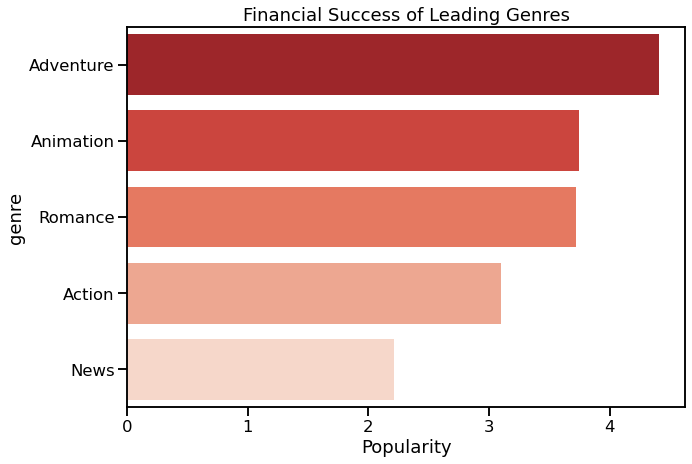

In [51]:
##### NOTE -- ESSENTIAL -- ADD AN "ALL OTHERS" ROW TOO FOR SOME SORT OF COMPARISON


leading_genres = df_genres.iloc[:5].sort_values(by='popularity_median', ascending=False)

sns.set_context('talk') 
sns.set_palette("Reds_r") #twilight_shifted_r also an option
f, ax = plt.subplots(1, 1, figsize=(10, 7), sharex=True)

x = leading_genres['genre']
y = leading_genres['profit_median']/10**6

sns.set_palette("Reds_r")
sns.barplot(data = leading_genres, y = 'genre', x = 'popularity_median', ax=ax, palette='Reds_r', orient='h')
#plt.ylabel('Genre')
plt.xlabel('Popularity')#('Median Movie Profit (Million $)')
sns.set_palette("Reds_r")
ax.set_title('Financial Success of Leading Genres')
#plt.savefig('images/Financial Success of Leading Genres.png')
sns.set_palette("Reds_r")

,genre_long,genre,profit_median,profit_mean,profit_rank,popularity_median,popularity_mean,popularity_rank,movie_ct
2,genre_romance,Romance,12211455.5,5.258693e+07,10,3.7175,6.810780,4,6737.0
5,genre_comedy,Comedy,15275343.5,7.148983e+07,8,2.0370,4.071102,12,25948.0
6,genre_animation,Animation,85294313.5,1.940365e+08,0,3.7480,6.619390,3,7132.0
9,genre_family,Family,36627518.0,1.283730e+08,4,1.9355,4.265355,15,6462.0
16,genre_action,Action,25023759.0,1.097484e+08,6,3.0990,5.194202,5,4940.0
17,genre_news,News,28031715.0,2.208677e+07,5,2.2130,4.349066,10,1562.0
25,genre_adventure,Adventure,57375039.0,1.904184e+08,2,4.4065,7.857636,1,1474.0


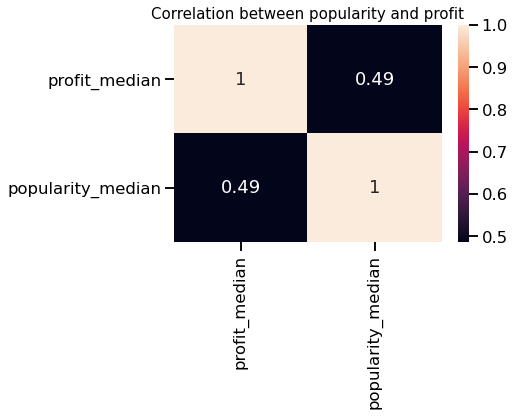

In [22]:
corrMatrix = df_genres[['profit_median', 'popularity_median']].dropna().corr()
#corrMatrix = tester[['profit_mean', 'popularity_mean']].dropna().corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation between popularity and profit", fontsize=15)
df_genres

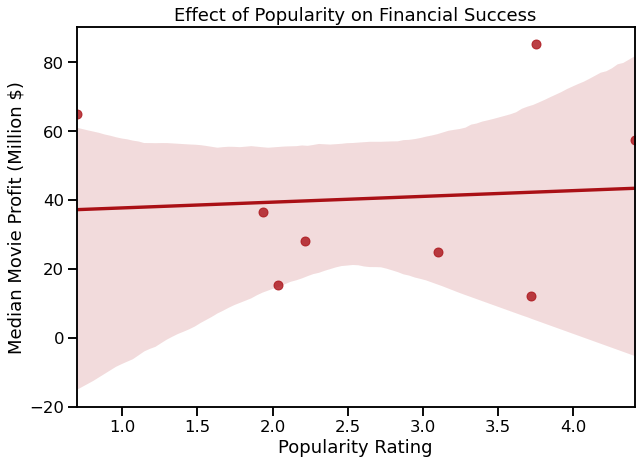

In [50]:
sns.set_context('talk') 
sns.set_palette("Reds_r") #twilight_shifted_r also an option
f, ax = plt.subplots(1, 1, figsize=(10, 7), sharex=True)

x = df_genres['popularity_median']
y = df_genres['profit_median']/10**6

sns.regplot(x=x, y=y, ax=ax)
plt.xlabel('Popularity Rating')
plt.ylabel('Median Movie Profit (Million $)')
ax.set_title('Effect of Popularity on Financial Success')
plt.savefig('images/Effect of Popularity on Financial Success.png')

# Notes From Call with Joel

- Consider frequency that each genre is produced. 

- Is there anything in this data that says starting with high popularity could lead to later profitability?

- If popularity is so vital, need to define more clearly how that is narrowed. Then, take a look at the most popular movies; profile these aspects to see "what works" and what doesn't

- Consider budgets too since that is especially relevant to companies breaking into a market

- Anything from Runtime?

- Look into top actors -- this could be something they would "need" to have in new films

- Try to create distinction between that the popular and unpopular factors are

- Tell them "what they should care about, and what they shouldn't care about". Second point is less necessary, but can be helpful

- Popular includes number of films produced in that genre, not just ratings

- Also look at distributions of this data, not just median. The company will also care about the confidence interval for these calculations.